In [1]:
#TODO remove
#interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [2]:
#Look at TODOs!!
!pip3 install seaborn


You are using pip version 8.1.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import sys, os, re
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
from essentia.streaming import *

import mir_eval
import seaborn as sns

In [4]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    print ('Processing audio file...', infile)
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class ChordSegment :
    startTime = 0.0
    endTime = 0.0
    symbol = ''
    def __init__(self, startTime, endTime, symbol):
        self.startTime = startTime
        self.endTime = endTime
        self.symbol = symbol
    def __repr__(self):
        return str(self.startTime) + '\t' + str(self.endTime) + '\t' + self.symbol
    
def mergeSegments(chordSegments) :
    if (len(chordSegments) < 2) :
        return chordSegments
    res = []
    currentSegment = chordSegments[0]
    for segment in chordSegments[1:] :
        if (segment.symbol == currentSegment.symbol):
            currentSegment.endTime = segment.endTime
        else:
            res.append(currentSegment)
            currentSegment = segment
    res.append(currentSegment)
    return res

def convertChordLabels(chordSegments) :
    for segment in chordSegments :
        segment.symbol = re.sub('m$', ':min', segment.symbol)
    return chordSegments


def toMirexLab(startTime, endTime, onsets, symbols, strengths) :
    if (len(onsets) < len(symbols) or len(symbols) != len(strengths)) :
        raise ValueError("inappropriate lists lengths")
    if (len(onsets) == len(symbols)) :
        onsets = np.concatenate((onsets, [endTime]))
    res = []
    if (startTime < onsets[0]) :
        res.append(ChordSegment(startTime, onsets[0], 'N'))
    for i in range(len(symbols)) :
        sym = symbols[i] if strengths[i] > 0 else 'N'
        res.append(ChordSegment(onsets[i], onsets[i+1], sym))
    if (res[-1].endTime < endTime) :
        res.append(ChordSegment(res[-1].endTime, endTime, 'N'))
    return convertChordLabels(mergeSegments(res))


def processFiles(inputDir, outputDir, processFunction) :
    for file in [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))] :
        name, ext = os.path.splitext(file)
        processFunction(os.path.join(inputDir, file), os.path.join(outputDir, name + '.lab'))

In [5]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, outfile, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)


    audio = essentia.standard.MonoLoader(filename = filename)()
    endTime = len(audio) / 44100.0
    stamps = np.arange(0, endTime, float(hopSize/44100.0))
    stamps = np.array([round(stamp,2) for stamp in stamps]) #2 decimals

    # workaround for Essentia behaviour I don't quite undestand: https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords.py
    syms = list(pool['chords.chords'][:-1])
    strengths = list(pool['chords.strength'][:-1])
    segments = toMirexLab(0.0, endTime, stamps, syms, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    print("\n", outfile, " was written")

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

In [6]:

def computeChordsByBeats(filename, outfile, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    
    print('Loading audio file...', filename)
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    beats = np.array([round(beat,2) for beat in beats])
    
    #ticks = beats[::4] # TODO: should we take each 4 beats??
    print("number of beats", len(beats))

    computeChordsByBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = computeChordsByBeats(pool['chroma.hpcp'], beats)
    
    segments = toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    print("\n", outfile, " was written")
    
    
    return chords, strengths, beats

In [7]:
def evaluateTriads(estimate_file, reference_file):
    '''
    expects .lab files
    performs mir_eval on triads
    return an object with '''
    (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals(reference_file)
    (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals(estimate_file)

    est_intervals, est_labels = mir_eval.util.adjust_intervals(
        est_intervals, est_labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)

    (intervals,
     ref_labels,
     est_labels) = mir_eval.util.merge_labeled_intervals(
        ref_intervals, ref_labels, est_intervals, est_labels)

    durations = mir_eval.util.intervals_to_durations(intervals)
    comparisons = mir_eval.chord.triads(ref_labels, est_labels)
    score = mir_eval.chord.weighted_accuracy(comparisons, durations)
    
    #create a result object and save all that might be handy
    class Object(object):
        pass
    
    result = Object()
    result.durations = durations
    result.comparisons = comparisons
    result.score = score
    result.intervals = intervals
    result.ref_labels = ref_labels
    result.est_labels = est_labels
    return result

In [32]:
#evaluate with mir_eval

#fake_test = "./estimated_chordBeat_labs/test_fake.lab"
audios_path = './audios_same_name/'
references_path = './ref_labs/'
estimated_chord_beat_path = './estimated_chordBeat_labs/'
estimated_chord_frame_path = './estimated_chordFrame_labs/'

track_name = 'maple_leaf_rag(hyman).flac'
track_name = 'giant_steps.flac'
lab_name = os.path.splitext(track_name)[0] + '.lab'

audiopath = audios_path + track_name
reference_lab = references_path + lab_name
estimated_chordBeat_lab = estimated_chord_beat_path + lab_name
estimated_chordFrame_lab = estimated_chord_frame_path + lab_name


#create lab files
song_tuning = tuning(audiopath)
computeChordsByBeats(audiopath, estimated_chordBeat_lab, tuningFrequency=song_tuning)
computeChordsByFrames(audiopath, estimated_chordFrame_lab, tuningFrequency=song_tuning)

#evaluate chord By Beat
beat_mir_eval_result = evaluateTriads(estimated_chordBeat_lab, reference_lab)

#evaluate chords By Frame
frame_mir_eval_result = evaluateTriads(estimated_chordFrame_lab, reference_lab)


Processing audio file... ./audios_same_name/giant_steps.flac
Loading audio file... ./audios_same_name/giant_steps.flac
number of beats 687

 ./estimated_chordBeat_labs/giant_steps.lab  was written

 ./estimated_chordFrame_labs/giant_steps.lab  was written


In [33]:
print("durations\n",len(beat_mir_eval_result.durations), beat_mir_eval_result.durations)
print("\n comparisons: \n",len(beat_mir_eval_result.comparisons),beat_mir_eval_result.comparisons)
print("\n score \n",beat_mir_eval_result.score)

print("score by beat", sum(beat_mir_eval_result.comparisons))



print("durations\n",len(frame_mir_eval_result.durations), beat_mir_eval_result.durations)
print("\n comparisons: \n",len(frame_mir_eval_result.comparisons),beat_mir_eval_result.comparisons)
print("\n score \n",frame_mir_eval_result.score)

print("score by frame",sum(frame_mir_eval_result.comparisons))

durations
 1153 [ 0.25  0.2   0.22 ...,  0.57  0.57  4.74]

 comparisons: 
 1153 [ 1.  0.  1. ...,  0.  0.  1.]

 score 
 0.210473208072
175.0
durations
 1259 [ 0.25  0.2   0.22 ...,  0.57  0.57  4.74]

 comparisons: 
 1259 [ 1.  0.  1. ...,  0.  0.  1.]

 score 
 0.132150313152
130.0


In [34]:
QUALITIES = {
    #           1     2     3     4  5     6     7
    'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
    'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [35]:
#Count label pairs(the ones that's wrongly detected, and sort them

#TODO: this should be a param
ref_labels = beat_mir_eval_result.ref_labels
comparisons = beat_mir_eval_result.comparisons
est_labels = beat_mir_eval_result.est_labels


#dict_comparelabels: overall; dict_foreachchord: count mistakes for each chord
dict_comparelabels = dict()
dict_foreachchord = dict()

for i in range(0, len(ref_labels)):
    #If there is no mistake, continue
    if comparisons[i] == 1: 
        continue
    #Count overall mistakes
    temp = [ref_labels[i], est_labels[i]] #[ground truth, estimated]
    tempstr = str(temp)
    if tempstr not in dict_comparelabels:
        dict_comparelabels[tempstr] = 0
    dict_comparelabels[tempstr]+=1

    #Count for each chord
    if ref_labels[i] not in dict_foreachchord:
        dict_foreachchord[ref_labels[i]] = dict()
    if est_labels[i] not in dict_foreachchord[ref_labels[i]]:
        dict_foreachchord[ref_labels[i]][est_labels[i]] = 0
    dict_foreachchord[ref_labels[i]][est_labels[i]]+=1


#pd_compare: count and rank mistakes, the first line is the most common mistake
pd_compare = pd.DataFrame.from_dict(dict_comparelabels, orient = 'index')
pd_compare.reset_index(drop=False, inplace=True)
pd_compare.columns = ['chord pairs','count']
pd_compare.sort_values(by=['count'], ascending=False, inplace = True)

#pd_compareeach: count and rank mistakes for every single chord
pd_compareeach = pd.DataFrame.from_dict(dict_foreachchord, orient = 'index')

pd_compare.head(5)

,chord pairs,count
156,"['Eb:maj7', 'C:min']",33
36,"['F#:7', 'D#:min']",24
60,"['F#:7', 'B']",24
32,"['Bb:7', 'G:min']",23
62,"['D:7', 'G']",23


In [36]:
pd_compareeach

,F:min,C,D,G#:min,F#:min,C#,F,G:min,B:min,D#:min,...,F#,E,E:min,A#,D:min,C#:min,N,D#,G,A#:min
A:min7,NaN,3.0,6.0,NaN,NaN,NaN,2.0,9.0,8.0,1.0,...,NaN,1.0,3.0,4.0,2.0,1.0,NaN,2.0,4.0,NaN
B:maj7,8.0,NaN,8.0,13.0,3.0,2.0,NaN,NaN,9.0,19.0,...,14.0,3.0,1.0,4.0,3.0,2.0,1.0,1.0,1.0,6.0
Bb:7,14.0,1.0,6.0,6.0,NaN,2.0,10.0,23.0,3.0,4.0,...,NaN,NaN,2.0,NaN,11.0,NaN,NaN,12.0,17.0,4.0
C#:min7,3.0,1.0,NaN,7.0,1.0,3.0,NaN,NaN,6.0,15.0,...,4.0,7.0,1.0,1.0,NaN,NaN,NaN,2.0,3.0,NaN
D:7,NaN,4.0,NaN,NaN,1.0,NaN,1.0,10.0,16.0,1.0,...,1.0,2.0,6.0,1.0,2.0,NaN,NaN,1.0,23.0,NaN
Eb:maj7,9.0,7.0,4.0,7.0,NaN,2.0,11.0,22.0,1.0,6.0,...,NaN,2.0,2.0,17.0,11.0,5.0,NaN,NaN,10.0,5.0
F#:7,4.0,1.0,NaN,1.0,NaN,3.0,NaN,1.0,5.0,24.0,...,NaN,5.0,1.0,2.0,1.0,3.0,NaN,2.0,NaN,3.0
F:min7,NaN,NaN,2.0,9.0,NaN,2.0,1.0,9.0,2.0,1.0,...,NaN,NaN,2.0,4.0,2.0,NaN,NaN,2.0,5.0,3.0
G:maj7,4.0,6.0,16.0,5.0,1.0,1.0,1.0,9.0,13.0,2.0,...,1.0,5.0,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN
N,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


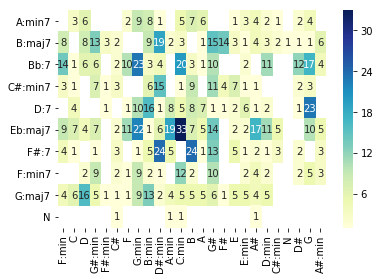

In [37]:
#Making a heatmap for mistakes the algorithm has made
#x axis is estimated chords, y axis is the ground truth
sns.heatmap(pd_compareeach, annot=True, fmt=".0f", cmap="YlGnBu")
plt.show()

In [38]:
#Find the most common mistakes for each chord(rank wrongly estimated chords by occurrence)
for rownum in range(0, len(pd_compareeach)):
    temprow = pd_compareeach.iloc[rownum]
    temprow.sort_values(ascending=False, inplace = True)
    temprow.dropna(inplace = True)
    #temprow.name is the current ground truth chord
    #temprow.index.values is the estimated chords
    #if you print temprow, it will print out the occurrence too
    print(temprow.name)
    print(temprow.index.values)

A:min7
['G:min' 'B:min' 'B' 'A' 'D' 'C:min' 'G' 'A#' 'E:min' 'C' 'D#' 'D:min' 'F'
 'C#:min' 'E' 'D#:min']
B:maj7
['D#:min' 'G#' 'F#' 'G#:min' 'B:min' 'D' 'F:min' 'A#:min' 'A#' 'E' 'C:min'
 'D:min' 'F#:min' 'A:min' 'C#:min' 'C#' 'E:min' 'G' 'A' 'N' 'D#']
Bb:7
['G:min' 'C:min' 'G' 'F:min' 'D#' 'D:min' 'G#' 'F' 'D' 'G#:min' 'A#:min'
 'D#:min' 'B:min' 'B' 'C#' 'E:min' 'A' 'C']
C#:min7
['D#:min' 'G#' 'B' 'E' 'G#:min' 'B:min' 'F#' 'G' 'C#' 'F:min' 'D#' 'A#'
 'E:min' 'C:min' 'F#:min' 'C']
D:7
['G' 'B:min' 'G:min' 'A:min' 'B' 'A' 'E:min' 'C:min' 'C' 'E' 'D:min' 'F#'
 'G#' 'D#' 'D#:min' 'A#' 'F' 'F#:min']
Eb:maj7
['C:min' 'G:min' 'A:min' 'A#' 'G#' 'F' 'D:min' 'G' 'F:min' 'B' 'G#:min' 'C'
 'D#:min' 'A' 'C#:min' 'A#:min' 'D' 'E' 'E:min' 'C#' 'B:min']
F#:7
['B' 'D#:min' 'G#' 'E' 'B:min' 'A:min' 'F:min' 'C#:min' 'C#' 'A#:min' 'D#'
 'A#' 'E:min' 'A' 'D:min' 'G:min' 'G#:min' 'C']
F:min7
['C:min' 'G#' 'G:min' 'G#:min' 'G' 'A#' 'A#:min' 'D#' 'D:min' 'E:min' 'B'
 'B:min' 'C#' 'D' 'D#:min' 'F']
G:maj7
['

In [39]:
#Count label pairs(the ones that's wrongly detected, and sort them

#TODO: this should be a param
ref_labels = frame_mir_eval_result.ref_labels
comparisons = frame_mir_eval_result.comparisons
est_labels = frame_mir_eval_result.est_labels


#dict_comparelabels: overall; dict_foreachchord: count mistakes for each chord
dict_comparelabels = dict()
dict_foreachchord = dict()

for i in range(0, len(ref_labels)):
    #If there is no mistake, continue
    if comparisons[i] == 1: 
        continue
    #Count overall mistakes
    temp = [ref_labels[i], est_labels[i]] #[ground truth, estimated]
    tempstr = str(temp)
    if tempstr not in dict_comparelabels:
        dict_comparelabels[tempstr] = 0
    dict_comparelabels[tempstr]+=1

    #Count for each chord
    if ref_labels[i] not in dict_foreachchord:
        dict_foreachchord[ref_labels[i]] = dict()
    if est_labels[i] not in dict_foreachchord[ref_labels[i]]:
        dict_foreachchord[ref_labels[i]][est_labels[i]] = 0
    dict_foreachchord[ref_labels[i]][est_labels[i]]+=1


#pd_compare: count and rank mistakes, the first line is the most common mistake
pd_compare = pd.DataFrame.from_dict(dict_comparelabels, orient = 'index')
pd_compare.reset_index(drop=False, inplace=True)
pd_compare.columns = ['chord pairs','count']
pd_compare.sort_values(by=['count'], ascending=False, inplace = True)

#pd_compareeach: count and rank mistakes for every single chord
pd_compareeach = pd.DataFrame.from_dict(dict_foreachchord, orient = 'index')

pd_compare.head(5)

,chord pairs,count
132,"['Eb:maj7', 'C:min']",62
52,"['Eb:maj7', 'G:min']",50
30,"['B:maj7', 'D#:min']",39
40,"['Bb:7', 'C:min']",35
51,"['D:7', 'G']",32


In [40]:
pd_compareeach

,G:min,B:min,G,C,C:min,D,D#,F:min,B,A#,...,E,E:min,A:min,C#:min,F#:min,C#,F,D#:min,A#:min,F#
A:min7,17,3.0,24.0,5.0,13,8.0,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B:maj7,2,15.0,NaN,3.0,19,8.0,5.0,3.0,NaN,2.0,...,2.0,NaN,1.0,1.0,1.0,1.0,2.0,39.0,4.0,5.0
Bb:7,31,3.0,11.0,3.0,35,9.0,21.0,3.0,2.0,NaN,...,NaN,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
C#:min7,2,12.0,1.0,1.0,9,3.0,4.0,1.0,19.0,1.0,...,2.0,NaN,1.0,NaN,1.0,NaN,NaN,8.0,NaN,1.0
D:7,12,17.0,32.0,1.0,7,NaN,NaN,1.0,2.0,NaN,...,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eb:maj7,50,3.0,13.0,7.0,62,7.0,NaN,8.0,3.0,9.0,...,NaN,NaN,4.0,NaN,NaN,1.0,5.0,12.0,NaN,NaN
F#:7,1,9.0,NaN,1.0,3,3.0,2.0,1.0,30.0,2.0,...,3.0,NaN,NaN,1.0,2.0,NaN,1.0,22.0,1.0,NaN
F:min7,4,NaN,1.0,NaN,29,1.0,25.0,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,14.0,2.0,NaN
G:maj7,15,21.0,NaN,4.0,8,30.0,NaN,2.0,3.0,NaN,...,2.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,1,1.0,1.0,NaN,1,3.0,NaN,1.0,NaN,2.0,...,NaN,NaN,NaN,NaN,1.0,2.0,NaN,1.0,1.0,NaN


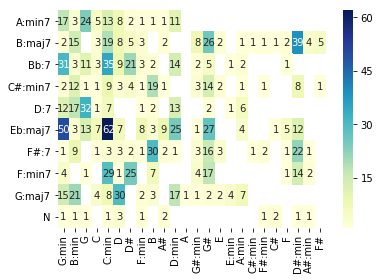

In [41]:
#Making a heatmap for mistakes the algorithm has made
#x axis is estimated chords, y axis is the ground truth
sns.heatmap(pd_compareeach, annot=True, fmt=".0f", cmap="YlGnBu")
plt.show()

In [42]:
#Find the most common mistakes for each chord(rank wrongly estimated chords by occurrence)
for rownum in range(0, len(pd_compareeach)):
    temprow = pd_compareeach.iloc[rownum]
    temprow.sort_values(ascending=False, inplace = True)
    temprow.dropna(inplace = True)
    #temprow.name is the current ground truth chord
    #temprow.index.values is the estimated chords
    #if you print temprow, it will print out the occurrence too
    print(temprow.name)
    print(temprow.index.values)

/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:2499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:3896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


A:min7
['G' 'G:min' 'C:min' 'D:min' 'D' 'C' 'B:min' 'D#' 'A#' 'B' 'F:min']
B:maj7
['D#:min' 'G#' 'C:min' 'B:min' 'G#:min' 'D' 'D#' 'F#' 'A#:min' 'F:min' 'C'
 'E' 'A#' 'F' 'G:min' 'A:min' 'C#:min' 'F#:min' 'C#']
Bb:7
['C:min' 'G:min' 'D#' 'D:min' 'G' 'D' 'G#' 'F:min' 'C' 'B:min' 'A:min'
 'G#:min' 'B' 'F' 'E:min']
C#:min7
['B' 'G#' 'B:min' 'C:min' 'D#:min' 'D#' 'D' 'G#:min' 'G:min' 'E' 'F:min'
 'A#' 'A:min' 'C' 'G' 'F#:min' 'F#']
D:7
['G' 'B:min' 'D:min' 'G:min' 'C:min' 'A:min' 'G#' 'B' 'E:min' 'F:min' 'C']
Eb:maj7
['C:min' 'G:min' 'G#' 'D:min' 'G' 'D#:min' 'A#' 'F:min' 'D' 'C' 'F' 'A:min'
 'B' 'B:min' 'C#' 'G#:min']
F#:7
['B' 'D#:min' 'G#' 'B:min' 'E' 'G#:min' 'C:min' 'D' 'A#' 'D#' 'F#:min' 'C'
 'A#:min' 'F:min' 'D:min' 'C#:min' 'F' 'G:min']
F:min7
['C:min' 'D#' 'G#' 'D#:min' 'B' 'G#:min' 'G:min' 'A#:min' 'F' 'D' 'G']
G:maj7
['D' 'B:min' 'D:min' 'G:min' 'C:min' 'A:min' 'E:min' 'C' 'B' 'E' 'G#'
 'F:min' 'G#:min' 'A']
N
['D' 'C#' 'A#' 'A#:min' 'D#:min' 'F#:min' 'F:min' 'C:min' 'G' 'B:min'

In [43]:
#scales
import json
json_path = './annotations/'

print(json_path)
print(len(os.listdir(json_path)))

keyDict = dict()
for file in os.listdir(json_path):
    file_path = os.path.join(json_path, file)
    print(file_path)
    with open(file_path, 'r') as f:
        loaded = json.load(f)
        if 'key' in loaded:
            key = loaded['key']
            print(key)
            if key not in keyDict:
                keyDict[key] = list()
            keyDict[key].append(file)

        



./annotations/
113
./annotations/evidence.json
Eb
./annotations/parkers_mood.json
Bb
./annotations/grandpas_spells.json
C
./annotations/east_st_louis.json
C:min
./annotations/honeysuckle_rose.json
Db
./annotations/four_or_five_times.json
Eb
./annotations/for_dancers_only.json
Eb
./annotations/haig_and_haig.json
Bb
./annotations/hotter_than_that.json
Eb
./annotations/st_thomas.json
C
./annotations/work_song.json
F:min
./annotations/bags_groove.json
F
./annotations/doggin_around.json
Bb
./annotations/weather_bird.json
Ab
./annotations/struttin_with_some_barbecue.json
Ab
./annotations/black_water_blues.json
A
./annotations/the_preacher.json
F
./annotations/breakfast_feud.json
Bb
./annotations/big_butter_and_eggman.json
G
./annotations/night_in_tunisia.json
D:min
./annotations/in_a_mellotone.json
Db
./annotations/boplicity.json
F
./annotations/blue_horizon.json
Eb
./annotations/pentup_house.json
G
./annotations/sweethearts_on_parade.json
F
./annotations/blue_serge.json
C:min
./annotations/

In [20]:
keyDict

{'A': ['black_water_blues.json', 'wrap_your_troubles_in_dreams.json'],
 'A:min': ['minor_swing.json'],
 'Ab': ['weather_bird.json',
  'struttin_with_some_barbecue.json',
  'dinah_fats_waller.json',
  'when_lights_are_low.json',
  'riverboat_shuffle.json',
  'airegin.json',
  'in_gloryland.json',
  'maple_leaf_rag(hyman).json',
  'maple_leaf_rag(braxton).json',
  'king_porter_stomp.json',
  'these_foolish_things.json',
  'the_stampede.json',
  'four_brothers.json',
  'dinah_red_nichols.json'],
 'B': ['daahoud.json'],
 'Bb': ['parkers_mood.json',
  'haig_and_haig.json',
  'doggin_around.json',
  'breakfast_feud.json',
  'blue_7.json',
  'cotton_tail_fitzgerald.json',
  'shaw_nuff.json',
  'from_monday_on.json',
  'crazeology.json',
  'manteca.json',
  'misterioso.json',
  'dead_man_blues.json',
  'west_coast_blues.json',
  'black_bottom_stomp.json',
  'he_s_funny_that_way.json',
  'cotton_tail.json',
  'i_got_rhythm.json',
  'blues_in_the_closet.json',
  'black_and_tan_fantasy.json',
  '